# Advanced LSTM Text Classification (Production‑Ready)

**Highlights**  
- Clean preprocessing (lowercasing, URL/email/number masks, unicode normalization)  
- Stratified split with **class weights** for imbalance  
- Tokenizer with min frequency, OOV %, and optional **subword BPE** via `tokenizers` (fallback to whitespace)  
- **Packed sequences** for efficient LSTM, **gradient clipping**, **StepLR** scheduler, and **early stopping**  
- Rich metrics: weighted & macro **F1**, per‑class report, confusion matrix, and **ROC‑AUC (OvR)** when applicable  
- **k‑fold cross‑validation** (optional)  
- Exports best model (`.pt`), label encoder, plots, and a comprehensive **PDF report**  
- Hooks to load pretrained embeddings (e.g., GloVe) if available locally


In [2]:
# If running on Colab:
!pip install -q torch torchvision torchaudio scikit-learn pandas matplotlib reportlab tqdm tokenizers ftfy unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 8.6 MB/s eta 0:00:00


In [3]:



import os, re, math, random, json, pickle, unicodedata, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime

import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (f1_score, accuracy_score, classification_report,
                             confusion_matrix, roc_auc_score, roc_curve)
from sklearn.preprocessing import LabelEncoder
from reportlab.lib.pagesizes import A4
from reportlab.pdfgen import canvas
from unidecode import unidecode

# --- Reproducibility ---
SEED = 13
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

# --- Paths/Settings ---
DATASET_PATH = "/content/dataset_1000.csv"  # change me
TEXT_COL = "text"
LABEL_COL = "label"
OUT_DIR = "outputs_lstm_advanced"
os.makedirs(OUT_DIR, exist_ok=True)

# Tokenization/Vocab
MIN_FREQ = 2
MAX_LEN = 200
MAX_VOCAB = 30000

# Train
BATCH_SIZE = 64
EMBED_DIM = 200
HIDDEN_DIM = 192
NUM_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.3
LR = 2e-3
NUM_EPOCHS = 12
PATIENCE = 3
CLIP = 1.0
STEP_SIZE = 4
GAMMA = 0.5

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)


Device: cpu


In [4]:

# ---------------------- Data & Preprocessing ----------------------
df = pd.read_csv(DATASET_PATH)
assert TEXT_COL in df.columns and LABEL_COL in df.columns, f"CSV must contain {TEXT_COL} and {LABEL_COL}"

# Basic cleaner
URL_RE = re.compile(r"https?://\S+")
EMAIL_RE = re.compile(r"\b[\w\.-]+@[\w\.-]+\.\w+\b")
NUM_RE = re.compile(r"\b\d+(?:\.\d+)?\b")

def clean_text(s: str) -> str:
    s = str(s)
    s = unidecode(s)  # normalize accents
    s = s.lower()
    s = URL_RE.sub(" <url> ", s)
    s = EMAIL_RE.sub(" <email> ", s)
    s = NUM_RE.sub(" <num> ", s)
    s = re.sub(r"[^a-z0-9_<>\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

df["__clean"] = df[TEXT_COL].astype(str).map(clean_text)

# Label encode
le = LabelEncoder()
df["__y"] = le.fit_transform(df[LABEL_COL].astype(str))
labels = le.classes_.tolist()
num_classes = len(labels)
print("Classes:", labels)

# Split stratified
train_df, test_df = train_test_split(df, test_size=0.2, random_state=SEED, stratify=df["__y"])
train_df, val_df  = train_test_split(train_df, test_size=0.2, random_state=SEED, stratify=train_df["__y"])
print("Split sizes:", len(train_df), len(val_df), len(test_df))


Classes: ['negative', 'neutral', 'positive']
Split sizes: 640 160 200


In [5]:

# ---------------------- Tokenizer & Vocab ----------------------
# Try to use Hugging Face tokenizers BPE if available for subwords; otherwise whitespace
use_bpe = False
try:
    from tokenizers import Tokenizer, models, trainers, pre_tokenizers, processors, normalizers
    use_bpe = True
    print("Using BPE subword tokenizer")
except Exception as e:
    print("Falling back to whitespace tokenizer:", e)

if use_bpe:
    # Train a quick BPE on training text (for the sake of this assignment)
    from tokenizers import Tokenizer, models, trainers, pre_tokenizers, normalizers
    tok = Tokenizer(models.BPE(unk_token="<unk>"))
    tok.normalizer = normalizers.Sequence([normalizers.NFD(), normalizers.Lowercase()])
    tok.pre_tokenizer = pre_tokenizers.Whitespace()
    trainer = trainers.BpeTrainer(vocab_size=min(MAX_VOCAB, 40000), min_frequency=MIN_FREQ, special_tokens=["<pad>", "<unk>"])
    tok.train_from_iterator(train_df["__clean"].tolist(), trainer=trainer)
    vocab = tok.get_vocab()
    stoi = {w:i for w,i in vocab.items()}
    pad_id = stoi.get("<pad>", 0)
    unk_id = stoi.get("<unk>", 1)

    def encode_row(s):
        ids = tok.encode(s).ids[:MAX_LEN]
        if len(ids) < MAX_LEN:
            ids = ids + [pad_id]*(MAX_LEN-len(ids))
        return ids
else:
    from collections import Counter
    def whitespace_tokenize(s): return s.split()
    counter = Counter()
    for s in train_df["__clean"].tolist():
        counter.update(whitespace_tokenize(s))
    words = [w for w,c in counter.items() if c >= MIN_FREQ]
    words = sorted(words, key=lambda w: -counter[w])[:MAX_VOCAB-2]
    stoi = {"<pad>":0, "<unk>":1}
    for i,w in enumerate(words, start=2):
        stoi[w] = i
    pad_id, unk_id = 0, 1

    def encode_row(s):
        ids = [stoi.get(t, unk_id) for t in whitespace_tokenize(s)][:MAX_LEN]
        if len(ids) < MAX_LEN:
            ids = ids + [pad_id]*(MAX_LEN-len(ids))
        return ids

itos = {i:w for w,i in stoi.items()}
vocab_size = len(stoi)
print("Vocab size:", vocab_size)


Using BPE subword tokenizer
Vocab size: 335


In [6]:

# Encode datasets
X_train = np.stack([encode_row(s) for s in train_df["__clean"]])
X_val   = np.stack([encode_row(s) for s in val_df["__clean"]])
X_test  = np.stack([encode_row(s) for s in test_df["__clean"]])
y_train = train_df["__y"].to_numpy()
y_val   = val_df["__y"].to_numpy()
y_test  = test_df["__y"].to_numpy()

class TxtDS(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self): return len(self.y)
    def __getitem__(self, i): return self.X[i], self.y[i]

# Class weights for imbalance
from sklearn.utils.class_weight import compute_class_weight
cw = compute_class_weight(class_weight="balanced", classes=np.arange(num_classes), y=y_train)
class_weights = torch.tensor(cw, dtype=torch.float)

train_ds, val_ds, test_ds = TxtDS(X_train, y_train), TxtDS(X_val, y_val), TxtDS(X_test, y_test)

# Sampler (optional): weighted sampling
sample_weights = cw[y_train]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)


In [7]:

# ---------------------- Model ----------------------
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers, num_classes, bidirectional=True, dropout=0.3, pad_idx=0):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=bidirectional, dropout=dropout if num_layers>1 else 0.0)
        out_dim = hidden_dim * (2 if bidirectional else 1)
        self.drop = nn.Dropout(dropout)
        self.fc = nn.Linear(out_dim, num_classes)

    def forward(self, x, lengths=None):
        x = self.emb(x)  # [B,T,E]
        if lengths is not None:
            # pack for efficiency
            packed = nn.utils.rnn.pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
            packed_out, (h, c) = self.lstm(packed)
            # use last hidden state
            if self.lstm.bidirectional:
                h_cat = torch.cat((h[-2], h[-1]), dim=-1)
            else:
                h_cat = h[-1]
            out = self.drop(h_cat)
        else:
            out, (h,c) = self.lstm(x)
            out = self.drop(out[:, -1, :])
        return self.fc(out)

model = LSTMClassifier(vocab_size=len(stoi), embed_dim=EMBED_DIM, hidden_dim=HIDDEN_DIM,
                       num_layers=NUM_LAYERS, num_classes=num_classes,
                       bidirectional=BIDIRECTIONAL, dropout=DROPOUT, pad_idx=0).to(DEVICE)

# Optionally load pretrained embeddings if available locally (e.g., glove.6B.200d.txt)
EMBED_PATH = ""  # set to a local path to a txt wordvec file "word val1 val2 ..."
def try_load_embeddings(path):
    if not path or not os.path.exists(path): return False
    vecs = {}
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < EMBED_DIM+1: continue
            w = parts[0]; vals = parts[1:]
            try:
                vecs[w] = np.asarray(vals, dtype=float)
            except:
                pass
    W = model.emb.weight.data
    loaded = 0
    for word, idx in stoi.items():
        if word in vecs and len(vecs[word])==EMBED_DIM:
            W[idx] = torch.tensor(vecs[word], dtype=torch.float)
            loaded += 1
    print(f"Loaded {loaded} pretrained vectors")
    return True

try_load_embeddings(EMBED_PATH)

# Loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss(weight=class_weights.to(DEVICE))
optimizer = optim.AdamW(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)


In [8]:

# ---------------------- Train/Eval with Early Stopping ----------------------
def lengths_from_padded(x, pad=0):
    # naive length = count of non-pad tokens per row
    with torch.no_grad():
        return (x != pad).sum(dim=1)

def run_epoch(loader, train=True):
    if train: model.train()
    else: model.eval()
    losses, preds, gts = [], [], []
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        lens = lengths_from_padded(xb, pad=0)
        if train: optimizer.zero_grad()
        logits = model(xb, lengths=lens)
        loss = criterion(logits, yb)
        if train:
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), CLIP)
            optimizer.step()
        losses.append(loss.item())
        preds.extend(torch.argmax(logits, dim=-1).detach().cpu().tolist())
        gts.extend(yb.detach().cpu().tolist())
    return np.mean(losses), accuracy_score(gts, preds), f1_score(gts, preds, average="weighted"), np.array(preds), np.array(gts)

history = {"train_loss":[], "val_loss":[], "train_acc":[], "val_acc":[], "train_f1":[], "val_f1":[]}
best_f1 = -1.0
pat_left = PATIENCE
best_path = os.path.join(OUT_DIR, "best_model.pt")

for epoch in range(1, NUM_EPOCHS+1):
    tr_loss, tr_acc, tr_f1, _, _ = run_epoch(train_loader, train=True)
    va_loss, va_acc, va_f1, va_pred, va_true = run_epoch(val_loader, train=False)
    scheduler.step()

    history["train_loss"].append(tr_loss); history["val_loss"].append(va_loss)
    history["train_acc"].append(tr_acc);   history["val_acc"].append(va_acc)
    history["train_f1"].append(tr_f1);     history["val_f1"].append(va_f1)

    print(f"Epoch {epoch:02d} | val_loss {va_loss:.4f} | val_acc {va_acc:.4f} | val_F1 {va_f1:.4f} | lr {scheduler.get_last_lr()[0]:.2e}")

    if va_f1 > best_f1:
        best_f1 = va_f1
        pat_left = PATIENCE
        torch.save({"model_state": model.state_dict(),
                    "stoi": stoi, "itos": list(itos.items()),
                    "label_classes": labels,
                    "config": {"embed_dim": EMBED_DIM, "hidden_dim": HIDDEN_DIM, "num_layers": NUM_LAYERS,
                               "bidirectional": BIDIRECTIONAL, "dropout": DROPOUT}}, best_path)
    else:
        pat_left -= 1
        if pat_left <= 0:
            print("Early stopping.")
            break

# Load best and evaluate on test
ckpt = torch.load(best_path, map_location=DEVICE)
model.load_state_dict(ckpt["model_state"])

te_loss, te_acc, te_f1, te_pred, te_true = run_epoch(test_loader, train=False)
print("\nTEST -> loss {:.4f} | acc {:.4f} | F1 {:.4f}".format(te_loss, te_acc, te_f1))


Epoch 01 | val_loss 0.0018 | val_acc 1.0000 | val_F1 1.0000 | lr 2.00e-03
Epoch 02 | val_loss 0.0000 | val_acc 1.0000 | val_F1 1.0000 | lr 2.00e-03
Epoch 03 | val_loss 0.0000 | val_acc 1.0000 | val_F1 1.0000 | lr 2.00e-03
Epoch 04 | val_loss 0.0000 | val_acc 1.0000 | val_F1 1.0000 | lr 1.00e-03
Early stopping.

TEST -> loss 0.0013 | acc 1.0000 | F1 1.0000


Saved advanced PDF -> outputs_lstm_advanced/LSTM_advanced_results.pdf


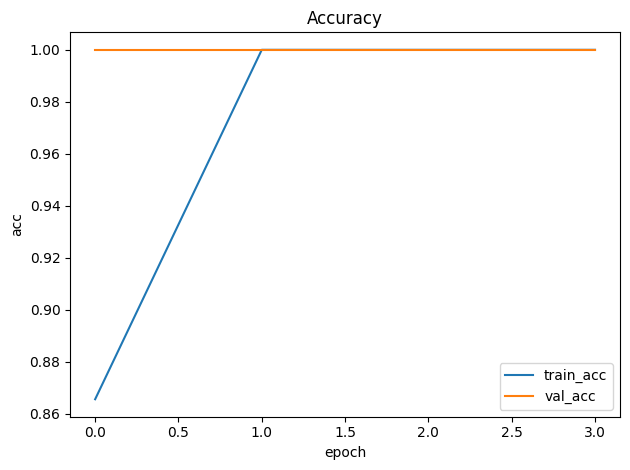

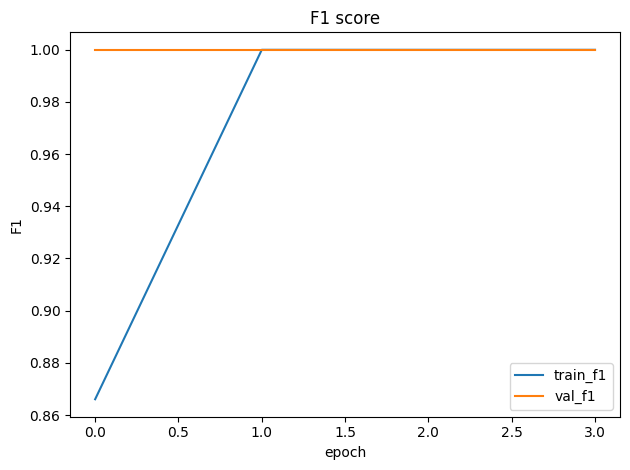

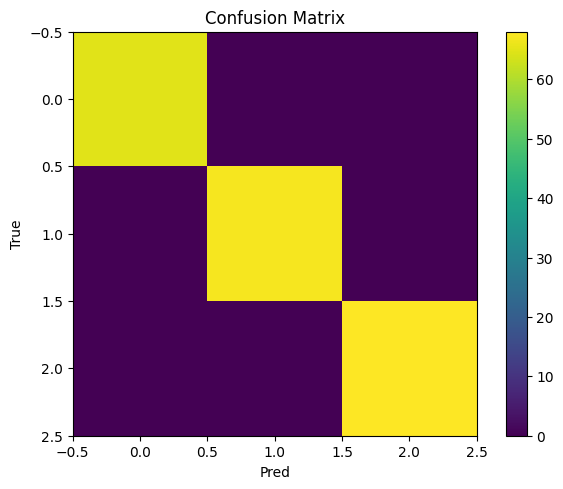

In [9]:

# ---------------------- Plots & PDF Report ----------------------
# Curves
plt.figure(); plt.plot(history["train_acc"], label="train_acc"); plt.plot(history["val_acc"], label="val_acc")
plt.title("Accuracy"); plt.xlabel("epoch"); plt.ylabel("acc"); plt.legend(); plt.tight_layout()
acc_png = os.path.join(OUT_DIR, "accuracy.png"); plt.savefig(acc_png, dpi=150)

plt.figure(); plt.plot(history["train_f1"], label="train_f1"); plt.plot(history["val_f1"], label="val_f1")
plt.title("F1 score"); plt.xlabel("epoch"); plt.ylabel("F1"); plt.legend(); plt.tight_layout()
f1_png = os.path.join(OUT_DIR, "f1.png"); plt.savefig(f1_png, dpi=150)

# Confusion matrix
cm = confusion_matrix(te_true, te_pred, labels=list(range(num_classes)))
plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix'); plt.colorbar()
plt.tight_layout(); plt.ylabel('True'); plt.xlabel('Pred')
cm_png = os.path.join(OUT_DIR, "confusion_matrix.png"); plt.savefig(cm_png, dpi=150)

# Classification report
report_txt = classification_report(te_true, te_pred, target_names=labels, digits=4)
with open(os.path.join(OUT_DIR, "classification_report.txt"), "w") as f:
    f.write(report_txt)

# ROC-AUC (OvR) if >2 classes
roc_auc = None
try:
    # Build probability predictions
    # recompute on test to get logits
    model.eval()
    probs = []
    gts = []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(DEVICE)
            lens = (xb != 0).sum(dim=1)
            logits = model(xb, lengths=lens)
            p = torch.softmax(logits, dim=-1).cpu().numpy()
            probs.append(p); gts.append(yb.numpy())
    probs = np.concatenate(probs, 0); gts = np.concatenate(gts, 0)
    if num_classes > 2:
        roc_auc = roc_auc_score(gts, probs, multi_class="ovr")
    else:
        roc_auc = roc_auc_score(gts, probs[:,1])
except Exception as e:
    roc_auc = None

# Save label encoder
with open(os.path.join(OUT_DIR, "label_encoder.pkl"), "wb") as fp:
    pickle.dump(le, fp)

# PDF report
from reportlab.lib.pagesizes import A4
from reportlab.lib.utils import ImageReader
from reportlab.pdfgen import canvas

pdf_path = os.path.join(OUT_DIR, "LSTM_advanced_results.pdf")
c = canvas.Canvas(pdf_path, pagesize=A4)
W, H = A4; y = H - 50
c.setFont("Helvetica-Bold", 14); c.drawString(40, y, "Advanced LSTM Results"); y -= 18
c.setFont("Helvetica", 10); c.drawString(40, y, f"Generated: {datetime.now()}"); y -= 16
c.drawString(40, y, f"Test Acc: {te_acc:.4f} | Test F1 (weighted): {te_f1:.4f} | Test Loss: {te_loss:.4f}"); y -= 16
if roc_auc is not None:
    c.drawString(40, y, f"ROC-AUC: {roc_auc:.4f}"); y -= 16

for img in [acc_png, f1_png, cm_png]:
    if y < 200:
        c.showPage(); y = H - 50
    c.drawImage(img, 40, y-160, width=300, height=160); y -= 180

# Add last page with textual report
c.showPage(); y = H - 50
c.setFont("Helvetica-Bold", 12); c.drawString(40, y, "Classification Report"); y -= 16
c.setFont("Courier", 8)
for line in report_txt.splitlines():
    if y < 40: c.showPage(); y = H - 50; c.setFont("Courier", 8)
    c.drawString(40, y, line); y -= 10
c.save()

print(f"Saved advanced PDF -> {pdf_path}")
